# London city tours by venue themes

This project is part of **Capstone Project - The Battle of Neighborhoods** on [Applied Data Science Capstone on Coursera](https://www.coursera.org/learn/applied-data-science-capstone)

## Problem statement

As a London tour agency, we are planning to promote new city tours in Greater London. We would like to know which boroughs are similar or different from the others by venues in each area. This will help us make a decision which tourist groups would be targeted in our tours e.g. "Food Lover" or "Shopping Lover". Apart from the tour agency's benefit, tourists can benefit from this project. They can look at results and plan for their trips by themselves whether they want to visit similar or different boroughs in Greater London.

## Data

London boroughs are scraped from [Wikipedia](https://en.wikipedia.org/wiki/Greater_London)

![](https://github.com/BOSS-Danuphan/Coursera_Capstone/raw/master/London%20boroughs.png)

Venue list can be retrieved from [Foursquare API](https://developer.foursquare.com/) by the ["*Get Venue Recommendations*" endpoint](https://developer.foursquare.com/docs/api/venues/explore) .

For an additional detail of venue categories, we will use their root categories rather than leaf nodes. This will help understand an overview of each borough because categories given by the enpoints are **too sparse**. For example,

>Original categories | Root categories
>--- | ---
>Bistro | Food
>Dim Sum Restaurant | Food
>Movie Theater | Arts & Entertainment

These information can retrieved from  the ["*Get Venue Categories*" endpoint](https://developer.foursquare.com/docs/api/venues/categories)

## Methodology

In [0]:
# Import useful package
import getpass

import requests
import json
from bs4 import BeautifulSoup
from urllib.parse import urlencode

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

import folium
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
# Add credentials for Foursquare API
CLIENT_ID=getpass.getpass('CLIENT_ID: ')
CLIENT_SECRET=getpass.getpass('CLIENT_SECRET: ')
VERSION='20190601'
CREDENTIAL_PARAM='client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)

CLIENT_ID: ··········
CLIENT_SECRET: ··········


### Data Preparation

#### Venue Categories

In [0]:
def get_category_tree(category, tree={}):
  '''To extract necessary information from Categories API'''
  if not category['categories']:
    return tree

  tree['categories'] = []
  for cat in category['categories']:
    subtree = {
        'id': cat['id'],
        'name': cat['name']
    }
    get_category_tree(cat, subtree)
    tree['categories'].append(subtree)
  return tree

url = 'https://api.foursquare.com/v2/venues/categories?{}'.format(CREDENTIAL_PARAM)
res = requests.get(url).json()["response"]

root = {'name': 'root'}
get_category_tree(res,root)

In [5]:
def print_tree(category, level=0):
  '''To visualize venue category tree'''
  print('  ' * level + category['name'])
  if category.get('categories'):
    for cat in category['categories']:
      print_tree(cat, level+1)
print_tree(root)

root
  Arts & Entertainment
    Amphitheater
    Aquarium
    Arcade
    Art Gallery
    Bowling Alley
    Casino
    Circus
    Comedy Club
    Concert Hall
    Country Dance Club
    Disc Golf
    Exhibit
    General Entertainment
    Go Kart Track
    Historic Site
    Karaoke Box
    Laser Tag
    Memorial Site
    Mini Golf
    Movie Theater
      Drive-in Theater
      Indie Movie Theater
      Multiplex
    Museum
      Art Museum
      Erotic Museum
      History Museum
      Planetarium
      Science Museum
    Music Venue
      Jazz Club
      Piano Bar
      Rock Club
    Pachinko Parlor
    Performing Arts Venue
      Dance Studio
      Indie Theater
      Opera House
      Theater
    Pool Hall
    Public Art
      Outdoor Sculpture
      Street Art
    Racecourse
    Racetrack
    Roller Rink
    Salsa Club
    Samba School
    Stadium
      Baseball Stadium
      Basketball Stadium
      Cricket Ground
      Football Stadium
      Hockey Arena
      Rugby Stadium
      S

In [7]:
def assign_category_mapper(category, mapper={}, parent=None):
    '''To create mapper from a category to its root category'''
    if parent is None:
        parent = category['name']
    mapper[category['name']] = parent
    if category.get('categories'):
        for child in category['categories']:
            assign_category_mapper(child, mapper, parent)
    return mapper

category_mapper = {}
for child in root['categories']:
    assign_category_mapper(child, category_mapper)

def get_category_parent(category, mapper=category_mapper):
    '''To return root category by a given category'''
    return category_mapper.get(category)
category_mapper

{'ATM': 'Shop & Service',
 'Abruzzo Restaurant': 'Food',
 'Acai House': 'Food',
 'Accessories Store': 'Shop & Service',
 'Acehnese Restaurant': 'Food',
 'Acupuncturist': 'Professional & Other Places',
 'Adult Boutique': 'Shop & Service',
 'Adult Education Center': 'Professional & Other Places',
 'Advertising Agency': 'Professional & Other Places',
 'Afghan Restaurant': 'Food',
 'African Restaurant': 'Food',
 'Agriturismo': 'Food',
 'Airport': 'Travel & Transport',
 'Airport Food Court': 'Travel & Transport',
 'Airport Gate': 'Travel & Transport',
 'Airport Lounge': 'Travel & Transport',
 'Airport Service': 'Travel & Transport',
 'Airport Terminal': 'Travel & Transport',
 'Airport Tram': 'Travel & Transport',
 'Alsatian Restaurant': 'Food',
 'Alternative Healer': 'Professional & Other Places',
 'American Restaurant': 'Food',
 'Amphitheater': 'Arts & Entertainment',
 'Andhra Restaurant': 'Food',
 'Anhui Restaurant': 'Food',
 'Animal Shelter': 'Professional & Other Places',
 'Antique Shop

#### London Boroughs

In [8]:
# Scrape London borough from Wikipedia
url = 'https://en.wikipedia.org/wiki/Greater_London'
source = requests.get(url).text
soup = BeautifulSoup(source, 'html.parser')
html_table = soup.find("table", {"class": "postcodeAreasTable"})
html_table = soup.find(id='Local_government').parent.find_next_sibling("table")

boroughs = []
for row in html_table.find_all('a'):
    name = list(row.stripped_strings)
    if name:
        name = name[0]
    else:
        continue
    boroughs.append(name)
boroughs

['City of London',
 'City of Westminster',
 'Kensington and Chelsea',
 'Hammersmith and Fulham',
 'Wandsworth',
 'Lambeth',
 'Southwark',
 'Tower Hamlets',
 'Hackney',
 'Islington',
 'Camden',
 'Brent',
 'Ealing',
 'Hounslow',
 'Richmond',
 'Kingston',
 'Merton',
 'Sutton',
 'Croydon',
 'Bromley',
 'Lewisham',
 'Greenwich',
 'Bexley',
 'Havering',
 'Barking and Dagenham',
 'Redbridge',
 'Newham',
 'Waltham Forest',
 'Haringey',
 'Enfield',
 'Barnet',
 'Harrow',
 'Hillingdon']

In [9]:
# London Latitude/Longitude
location = Nominatim(user_agent="trt_explorer").geocode("London, UK")
London_loc = {'latitude': location.latitude, 'longitude': location.longitude}
London_loc

{'latitude': 51.5073219, 'longitude': -0.1276474}

#### Venues by London boroughs

In [0]:
def get_nearby_venues(loc_names, origin='', section='', limit=30):

    column_names = ['Borough',
                    'Latitude',
                    'Longitude']
    df_head = pd.DataFrame(columns=column_names)

    venues_list=[]
    for loc_name in loc_names:

        # create the API request URL
        params = {'near': loc_name + ' ' + origin, 'limit': limit}
        if section:
            params['section'] = section

        url = 'https://api.foursquare.com/v2/venues/explore?{}&{}'.format(
                  CREDENTIAL_PARAM, urlencode(params))

        # make the GET request
        res = requests.get(url).json()["response"]
        center_lat = res['geocode']['center']['lat']
        center_lng = res['geocode']['center']['lng']
        res_venues = res['groups'][0]['items']

        df_head = df_head.append({
            'Borough': loc_name,
            'Latitude': center_lat,
            'Longitude': center_lng
        }, ignore_index=True)

        venues_list.append([(
            loc_name,
            center_lat,
            center_lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            get_category_parent(v['venue']['categories'][0]['name'])) for v in res_venues])

    df_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    df_venues.columns = ['Borough',
                         'Latitude',
                         'Longitude',
                         'Venue', 
                         'Venue Latitude', 
                         'Venue Longitude', 
                         'Venue Category']

    return (df_head, df_venues)

df_head, df_venues = get_nearby_venues(boroughs, origin='London', section='')
venue_categories = pd.unique(df_venues['Venue Category']).tolist()

In [19]:
print(df_head.shape)
df_head.head()

(33, 3)


,Borough,Latitude,Longitude
0,City of London,51.50853,-0.12574
1,City of Westminster,51.50000,-0.11667
2,Kensington and Chelsea,51.50378,-0.18928
3,Hammersmith and Fulham,51.50000,-0.25000
4,Wandsworth,51.45770,-0.20784


In [20]:
print(df_venues.shape)
df_venues.head()

(990, 7)


,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,City of London,51.50853,-0.12574,Hampstead Heath,51.559622,-0.164921,Outdoors & Recreation
1,City of London,51.50853,-0.12574,Hyde Park,51.507781,-0.162392,Outdoors & Recreation
2,City of London,51.50853,-0.12574,Regent's Park,51.530479,-0.153766,Outdoors & Recreation
3,City of London,51.50853,-0.12574,Greenwich Park,51.477521,0.000858,Outdoors & Recreation
4,City of London,51.50853,-0.12574,Primrose Hill,51.539262,-0.161941,Outdoors & Recreation


In [21]:
# create map
loc_map = folium.Map(location=[London_loc['latitude'], London_loc['longitude']],
                     zoom_start=10)

# # set color scheme for venue categories
# x = np.arange(len(venue_categories))
# ys = [i + x + (i*x)**2 for i in range(len(venue_categories))]
# colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
# rainbow = [colors.rgb2hex(i) for i in colors_array]

# # add venue markers to the map
# for lat, lon, name, category in zip(df_venues['Venue Latitude'], df_venues['Venue Longitude'], df_venues['Venue'], df_venues['Venue Category']):
#     label = folium.Popup("{} ({})".format(name, category))
#     folium.CircleMarker(
#         [lat, lon],
#         radius=2,
#         popup=label,
#         color=rainbow[venue_categories.index(category)],
#         opacity=0.7,
#         fill=True,
#         fill_color=rainbow[venue_categories.index(category)],
#         fill_opacity=0.7).add_to(loc_map)

# add borough markers to the map
for lat, lon, name in zip(df_head['Latitude'], df_head['Longitude'], df_head['Borough']):
    label = folium.Popup(name)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(loc_map)

loc_map

In [70]:
# create map
loc_map = folium.Map(location=[London_loc['latitude'], London_loc['longitude']],
                     zoom_start=10)

# set color scheme for venue categories
x = np.arange(len(venue_categories))
ys = [i + x + (i*x)**2 for i in range(len(venue_categories))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add venue markers to the map
for lat, lon, name, category in zip(df_venues['Venue Latitude'], df_venues['Venue Longitude'], df_venues['Venue'], df_venues['Venue Category']):
    label = folium.Popup("{} ({})".format(name, category))
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[venue_categories.index(category)],
        opacity=0.7,
        fill=True,
        fill_color=rainbow[venue_categories.index(category)],
        fill_opacity=0.7).add_to(loc_map)

# add borough markers to the map
for lat, lon, name in zip(df_head['Latitude'], df_head['Longitude'], df_head['Borough']):
    label = folium.Popup(name)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='gray',
        fill_opacity=0.7).add_to(loc_map)

loc_map

### Clustering Venues

In [33]:
# One hot encoding
df_loc_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# Add location name column to the first column
df_loc_onehot['Borough'] = df_venues['Borough']
fixed_columns = [df_loc_onehot.columns[-1]] + list(df_loc_onehot.columns[:-1])
df_loc_onehot = df_loc_onehot[fixed_columns]

print(df_loc_onehot.shape)
df_loc_onehot.sample(5)

(990, 8)


,Borough,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
915,Barnet,0,0,0,0,0,1,0
976,Hillingdon,0,1,0,0,0,0,0
510,Sutton,0,1,0,0,0,0,0
148,Wandsworth,0,0,0,0,0,1,0
951,Harrow,0,1,0,0,0,0,0


In [34]:
# Group venues by boroughs
df_loc_grouped = df_loc_onehot.groupby('Borough').mean().reset_index()
print(df_loc_grouped.shape)
df_loc_grouped.sample(5)

(33, 8)


,Borough,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
10,Enfield,0.033333,0.466667,0.166667,0.100000,0.0,0.200000,0.033333
18,Hounslow,0.000000,0.466667,0.033333,0.066667,0.0,0.366667,0.066667
19,Islington,0.133333,0.433333,0.133333,0.100000,0.0,0.200000,0.000000
28,Southwark,0.166667,0.200000,0.133333,0.133333,0.0,0.266667,0.100000
29,Sutton,0.000000,0.500000,0.133333,0.233333,0.0,0.133333,0.000000


In [39]:
# Show the most common venues
def return_most_common_venues(row):
    row_categories = row.iloc[1:]    
    return row_categories.sort_values(ascending=False).index.values

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(len(venue_categories)):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_venues_sorted = pd.DataFrame(columns=columns)
df_venues_sorted['Borough'] = df_loc_grouped['Borough']

for ind in np.arange(df_loc_grouped.shape[0]):
    df_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_loc_grouped.iloc[ind, :])

df_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Barking and Dagenham,Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Professional & Other Places
1,Barnet,Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,Travel & Transport,Arts & Entertainment
2,Bexley,Food,Outdoors & Recreation,Nightlife Spot,Shop & Service,Arts & Entertainment,Travel & Transport,Professional & Other Places
3,Brent,Food,Outdoors & Recreation,Shop & Service,Arts & Entertainment,Travel & Transport,Professional & Other Places,Nightlife Spot
4,Bromley,Food,Shop & Service,Nightlife Spot,Outdoors & Recreation,Travel & Transport,Professional & Other Places,Arts & Entertainment


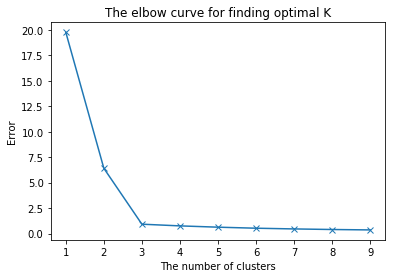

In [51]:
# Find optimal K for K-Mean algorithm
df_loc_grouped_clustering = df_loc_grouped.drop('Borough', 1)

possible_Ks = np.arange(1,10)
errors = []
for kcluster in possible_Ks:
    kmeans = KMeans(n_clusters=kcluster, n_init=40, random_state=0).fit(df_loc_grouped_clustering)
    errors.append(kmeans.inertia_)

plt.plot(possible_Ks, errors, marker='x')
plt.ylabel('Error')
plt.xlabel('The number of clusters')
plt.xticks(possible_Ks)
plt.title('The elbow curve for finding optimal K')
plt.show()

In [52]:
# set optimal number of clusters
kclusters = 3

df_loc_grouped_clustering = df_loc_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init=30, random_state=0).fit(df_loc_grouped_clustering)

# add clustering labels
try:
    df_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
except:
    pass
try:
    df_loc_grouped.drop(['Cluster Labels'], axis=1, inplace=True)
except:
    pass
df_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
df_loc_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_loc_merged = df_head.join(df_venues_sorted.set_index('Borough'), on='Borough')
df_loc_merged.sort_values('Cluster Labels')

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
24,Barking and Dagenham,51.55000,0.11667,0,Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Professional & Other Places
22,Bexley,51.44162,0.14866,0,Food,Outdoors & Recreation,Nightlife Spot,Shop & Service,Arts & Entertainment,Travel & Transport,Professional & Other Places
6,Southwark,51.50000,-0.08333,0,Shop & Service,Food,Arts & Entertainment,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Professional & Other Places
7,Tower Hamlets,51.51667,-0.05000,0,Shop & Service,Food,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Professional & Other Places,Arts & Entertainment
8,Hackney,51.55000,-0.05000,0,Shop & Service,Food,Nightlife Spot,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Professional & Other Places
9,Islington,51.53622,-0.10304,0,Food,Shop & Service,Nightlife Spot,Arts & Entertainment,Outdoors & Recreation,Travel & Transport,Professional & Other Places
13,Hounslow,51.46839,-0.36092,0,Food,Shop & Service,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,Arts & Entertainment
11,Brent,51.55306,-0.30230,0,Food,Outdoors & Recreation,Shop & Service,Arts & Entertainment,Travel & Transport,Professional & Other Places,Nightlife Spot
0,City of London,51.50853,-0.12574,1,Outdoors & Recreation,Shop & Service,Nightlife Spot,Food,Travel & Transport,Arts & Entertainment,Professional & Other Places
26,Newham,51.51667,0.03333,1,Outdoors & Recreation,Food,Arts & Entertainment,Shop & Service,Nightlife Spot,Travel & Transport,Professional & Other Places


In [53]:
cluster_stats = df_loc_grouped.drop('Borough', axis=1).groupby('Cluster Labels').mean()
pd.concat([pd.DataFrame({'Count': df_loc_grouped.drop('Borough', axis=1).groupby('Cluster Labels').count().iloc[:,0]}), cluster_stats], axis=1 )

,Count,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
Cluster Labels,,,,,,,,
0,8,0.087500,0.345833,0.104167,0.175000,0.000000,0.254167,0.033333
1,10,0.176667,0.236667,0.110000,0.320000,0.013333,0.093333,0.050000
2,15,0.035556,0.528889,0.133333,0.155556,0.002222,0.133333,0.011111


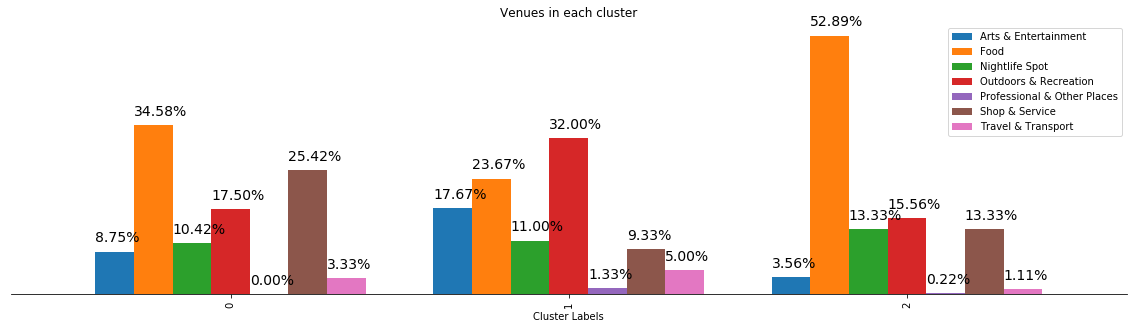

In [68]:
ax = cluster_stats.plot(kind='bar', figsize=(20,5), width=0.8)
ax.get_yaxis().set_ticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for p in ax.patches:
    label = "{:.2f}%".format(p.get_height()*100)
    ax.annotate(label, (p.get_x(), p.get_height() + 0.02), fontsize=14)

plt.title('Venues in each cluster')
plt.show()

In [71]:
# create map
cluster_labels = [
    'Cluster 0 - "Food and Shopping Lover"',
    'Cluster 1 - "Outdoors and Entertainments Lover"',
    'Cluster 2 - "Food Lover"'
]
map_clusters = folium.Map(location=[London_loc['latitude'], London_loc['longitude']], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(df_loc_merged['Latitude'], df_loc_merged['Longitude'], df_loc_merged['Borough'], df_loc_merged['Cluster Labels']):
    label = folium.Popup("{} | {}".format(name, cluster_labels[cluster]), max_width=200)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

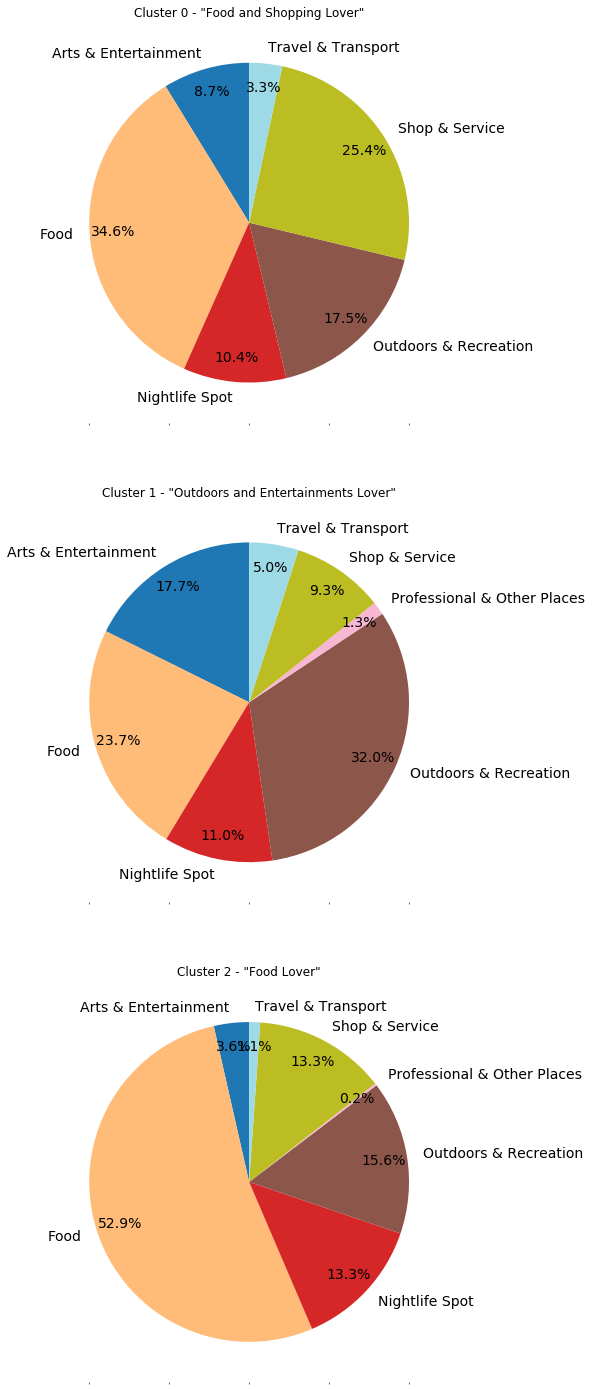

In [74]:
cluster_stats_pie_plot = cluster_stats.transpose()
cluster_stats_pie_plot.columns = ['Cluster ' + str(col) for col in cluster_stats_pie_plot.columns]
axes = cluster_stats_pie_plot.plot(kind='pie',
                                    subplots=True,
                                    figsize=(20,25),
                                    autopct=lambda pct: '{:.1f}%'.format(pct) if pct > 0 else '', 
                                    startangle=90,
                                    pctdistance=0.85,
                                    sort_columns=True,
                                    colormap='tab20',
                                    layout=(kclusters,1),
                                    fontsize=14,
                                    legend=False,
                                    title=['Cluster 0 - "Food and Shopping Lover"','Cluster 1 - "Outdoors and Entertainments Lover"','Cluster 2 - "Food Lover"'])
for ax in axes:
    ax[0].axes.get_yaxis().set_visible(False)
plt.show()